# Flight Delay Prediction

the goal of this project is to predict the flight that will be delayed for over 15 mins in January for US flights.

We will read the data first and remove unneeded features, hence the data contains the diverted and cancelled flights.

In [267]:
#importing libraries that we will using during this project
import numpy as np
import pandas as pd
import seaborn as sns

from pandas_profiling import ProfileReport as pr
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.linear_model import LogisticRegression


We will import flights data for January 2019 and January 2020, then we will concatenate dataframes together

In [178]:
#reading data and assign it to variables
jan19data = pd.read_csv('data/Jan_2019_ontime.csv')
jan20data = pd.read_csv('data/Jan_2020_ontime.csv')

#concatenate dataframes 
df = pd.concat([jan19data , jan20data.reindex(columns = jan19data.columns)], ignore_index= True)

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191331 entries, 0 to 1191330
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   DAY_OF_MONTH           1191331 non-null  int64  
 1   DAY_OF_WEEK            1191331 non-null  int64  
 2   OP_UNIQUE_CARRIER      1191331 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  1191331 non-null  int64  
 4   OP_CARRIER             1191331 non-null  object 
 5   TAIL_NUM               1188090 non-null  object 
 6   OP_CARRIER_FL_NUM      1191331 non-null  int64  
 7   ORIGIN_AIRPORT_ID      1191331 non-null  int64  
 8   ORIGIN_AIRPORT_SEQ_ID  1191331 non-null  int64  
 9   ORIGIN                 1191331 non-null  object 
 10  DEST_AIRPORT_ID        1191331 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    1191331 non-null  int64  
 12  DEST                   1191331 non-null  object 
 13  DEP_TIME               1168315 non-null  float64
 14  DEP_DEL15         

# Data Summary
our data now have 22 columns and 1191331 rows

## dataframe columns will use (15 columns):

* 'DAY_OF_MONTH': day of month.
* 'DAY_OF_WEEK': day number starting from monday.
* 'OP_UNIQUE_CARRIER': carrier identifier.
* 'TAIL_NUM': tail number.
* 'OP_CARRIER_FL_NUM': flight number.
* 'DEP_TIME_BLK': 24h time chunks.
* 'ORIGIN': departure airport identifier.
* 'ORIGIN_AIRPORT_ID': departure airport identifier.
* 'DEST': destination airport identfier.
* 'DEST_AIRPORT_ID' : destination airport identfier.
* 'DEP_TIME': actual departure time.
* 'DEP_DEL15': departure Delay Indicator, 15 Minutes or More. boolean
* 'DEP_TIME_BLK': departure Time Block, hourly intervals.
* 'ARR_TIME': actual arrival time.
* 'ARR_DEL15': arrival delay indicator, 15 Minutes or More. boolean
* 'DISTANCE': flight length.


## columns will drop (6 columns):
* 'OP_CARRIER_AIRLINE_ID': a different type of carrier identifier.
* 'OP_CARRIER': a different type of carrier identifier.
* 'ORIGIN_AIRPORT_SEQ_ID': a different type of airport identifier
* 'DEST_AIRPORT_SEQ_ID': a different type of airport identifier
* 'CANCELLED': cancelled flight indicator.
* 'DIVERTED': diverted flight indicator.



## Cleaning data

We will start by droping cancelled and diverted flights, unneeded columns and duplicated data

In [180]:
mask = (df['CANCELLED'] == 1 ) | (df['DIVERTED'] == 1 )
df.drop(df[mask].index, inplace = True)
df.drop(columns=['Unnamed: 21','OP_CARRIER_AIRLINE_ID','OP_CARRIER','ORIGIN_AIRPORT_SEQ_ID',
                 'DEST_AIRPORT_SEQ_ID','CANCELLED','DIVERTED'], inplace = True)
df.drop_duplicates(subset=['DAY_OF_MONTH','DAY_OF_WEEK','OP_UNIQUE_CARRIER','TAIL_NUM','OP_CARRIER_FL_NUM'])

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
0,1,2,9E,N8688C,3280,11953,GNV,10397,ATL,601.0,0.0,0600-0659,722.0,0.0,300.0
1,1,2,9E,N348PQ,3281,13487,MSP,11193,CVG,1359.0,0.0,1400-1459,1633.0,0.0,596.0
2,1,2,9E,N8896A,3282,11433,DTW,11193,CVG,1215.0,0.0,1200-1259,1329.0,0.0,229.0
3,1,2,9E,N8886A,3283,15249,TLH,10397,ATL,1521.0,0.0,1500-1559,1625.0,0.0,223.0
4,1,2,9E,N8974C,3284,10397,ATL,11778,FSM,1847.0,0.0,1900-1959,1940.0,0.0,579.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191325,31,5,9E,N909XJ,4811,14098,PHF,10397,ATL,558.0,0.0,0600-0659,754.0,0.0,508.0
1191326,31,5,9E,N331CA,4812,15412,TYS,11433,DTW,1002.0,1.0,0700-0759,1128.0,1.0,443.0
1191327,31,5,9E,N295PQ,4813,11433,DTW,12478,JFK,1747.0,0.0,1700-1759,1933.0,0.0,509.0
1191328,31,5,9E,N294PQ,4814,11996,GSP,12953,LGA,554.0,0.0,0600-0659,752.0,0.0,610.0


In [181]:
df = df.reset_index(drop=True)

In [182]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
0,1,2,9E,N8688C,3280,11953,GNV,10397,ATL,601.0,0.0,0600-0659,722.0,0.0,300.0
1,1,2,9E,N348PQ,3281,13487,MSP,11193,CVG,1359.0,0.0,1400-1459,1633.0,0.0,596.0
2,1,2,9E,N8896A,3282,11433,DTW,11193,CVG,1215.0,0.0,1200-1259,1329.0,0.0,229.0
3,1,2,9E,N8886A,3283,15249,TLH,10397,ATL,1521.0,0.0,1500-1559,1625.0,0.0,223.0
4,1,2,9E,N8974C,3284,10397,ATL,11778,FSM,1847.0,0.0,1900-1959,1940.0,0.0,579.0


We will try to read our data now

In [189]:
pr(df)

TypeError: concat() got an unexpected keyword argument 'join_axes'

we will use the features below that may affect the flight delay as shown below and we will try to add a weight to it depend on the affect:
DAY_OF_WEEK
CARRIER
DEP_TIME_BLK
TAIL_NUM
ORIGIN
DEST


,ARR_DEL15,DAY_OF_WEEK_W
DAY_OF_WEEK,,
4,34414.0,6
5,30724.0,5
3,27485.0,4
1,25291.0,3
7,23988.0,2
6,23084.0,1
2,22521.0,0


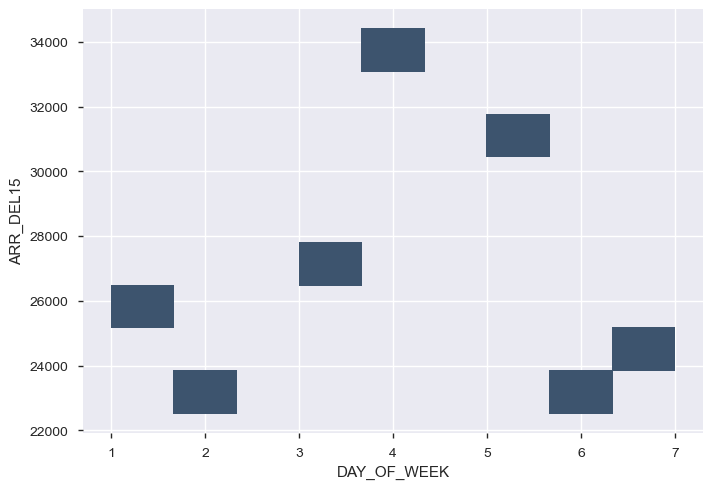

In [220]:
#frequncy of delay in day of the week
day_of_week_df = df[['DAY_OF_WEEK','ARR_DEL15']].groupby('DAY_OF_WEEK').sum()
sns.histplot(x = day_of_week_df.index,y= day_of_week_df['ARR_DEL15'],bins=9,kde=True)
day_of_week_df['DAY_OF_WEEK_W'] = pd.qcut(day_of_week_df['ARR_DEL15'], 7, labels = False)
day_of_week_df.sort_values(by = 'ARR_DEL15' , ascending=False)

,ARR_DEL15,CARRIER_W
OP_UNIQUE_CARRIER,,
WN,26432.0,16
AA,25089.0,15
OO,24716.0,14
DL,17862.0,13
UA,15391.0,12
MQ,10823.0,11
B6,10104.0,10
YX,9292.0,9
OH,8641.0,8


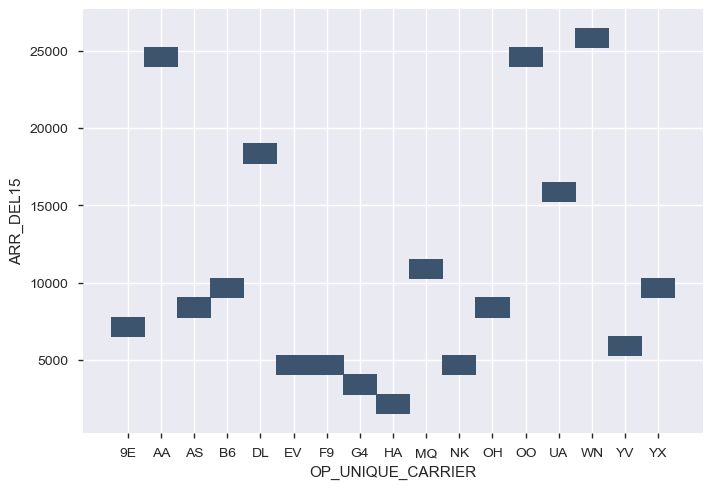

In [221]:
#frequncy of delay for each airline
airline_df = df[['OP_UNIQUE_CARRIER','ARR_DEL15']].groupby('OP_UNIQUE_CARRIER').sum()
airline_df['CARRIER_W'] = pd.qcut(airline_df['ARR_DEL15'], 17, labels = False)
sns.histplot(x = airline_df.index,y= airline_df['ARR_DEL15'],bins=20,kde=True)
airline_df.sort_values(by = 'ARR_DEL15' , ascending= False)

In [242]:
#frequncy of delay for each Departure time block
dep_time_blk_df = df[['DEP_TIME_BLK','ARR_DEL15']].groupby('DEP_TIME_BLK').sum()
dep_time_blk_df['DEP_TIME_BLK_W'] = pd.qcut(dep_time_blk_df['ARR_DEL15'], 19, labels = False)
dep_time_blk_df.sort_values(by='ARR_DEL15',ascending=False)


,ARR_DEL15,DEP_TIME_BLK_W
DEP_TIME_BLK,,
1700-1759,14875.0,18
1800-1859,14020.0,17
1600-1659,13292.0,16
1500-1559,12760.0,15
1900-1959,12640.0,14
1400-1459,12618.0,13
1200-1259,11761.0,12
1100-1159,11181.0,11
1300-1359,11101.0,10


In [245]:
#frequncy of delay for each aircraft
tail_num_df = df[['TAIL_NUM','ARR_DEL15']].groupby('TAIL_NUM').sum()
tail_num_df['TAIL_NUM_W'] = pd.qcut(tail_num_df['ARR_DEL15'], 10, labels = False)
tail_num_df.sort_values(by='ARR_DEL15',ascending=False)

#print(" number of flights for aircraft tail number : N253PS " 
    #  ,(df['TAIL_NUM'] == 'N253PS').sum(), " flights")

,ARR_DEL15,TAIL_NUM_W
TAIL_NUM,,
N253PS,110.0,9
N905JH,107.0,9
N228PS,105.0,9
N244PS,104.0,9
N612AE,104.0,9
...,...,...
N728AN,0.0,0
N727AN,0.0,0
N725AN,0.0,0


In [248]:
#frequncy of delay for each origin
origin_df = df[['ORIGIN','ARR_DEL15']].groupby('ORIGIN').sum()
origin_df['ORIGIN_W'] = pd.qcut(origin_df['ARR_DEL15'], 20, labels = False)
origin_df.sort_values(by = 'ARR_DEL15' , ascending=False)

,ARR_DEL15,ORIGIN_W
ORIGIN,,
ORD,12342.0,19
DFW,8802.0,19
ATL,7271.0,19
CLT,6622.0,19
DEN,5987.0,19
...,...,...
OWB,5.0,0
LWS,4.0,0
PPG,3.0,0


In [247]:
#frequncy of delay for each destiniation
dest_df = df[['DEST','ARR_DEL15']].groupby('DEST').sum()
dest_df['DEST_W'] = pd.qcut(dest_df['ARR_DEL15'], 20, labels = False)
dest_df.sort_values(by = 'ARR_DEL15' , ascending=False)

,ARR_DEL15,DEST_W
DEST,,
ORD,10170.0,19
DFW,8667.0,19
ATL,7263.0,19
LGA,7077.0,19
SFO,6114.0,19
...,...,...
OWB,3.0,0
ATY,3.0,0
ADK,3.0,0


After we created and calculate the weight for each feature we gonna use in our model to predict the delay, we will replace the data we gonna use with its weight:

In [250]:
#day of week weight
day_of_week_w = day_of_week_df.loc[df['DAY_OF_WEEK']].reset_index()
df['DAY_OF_WEEK_W'] = day_of_week_w['DAY_OF_WEEK_W']
#airline weight
airline_w = airline_df.loc[df['OP_UNIQUE_CARRIER']].reset_index()
df['CARRIER_W'] = airline_w['CARRIER_W']
#dep_time_blk weight
dep_time_blk_w = dep_time_blk_df.loc[df['DEP_TIME_BLK']].reset_index()
df['DEP_TIME_BLK_W'] = dep_time_blk_w['DEP_TIME_BLK_W']
#Tail num weight
tail_num_w = tail_num_df.loc[df['TAIL_NUM']].reset_index()
df['TAIL_NUM_W'] = tail_num_w['TAIL_NUM_W']
#origin weight
origin_w = origin_df.loc[df['ORIGIN']].reset_index()
df['ORIGIN_W'] = origin_w['ORIGIN_W']
#destination weight
dest_w = dest_df.loc[df['DEST']].reset_index()
df['DEST_W'] = dest_w['DEST_W']

In [253]:
df = df[['DAY_OF_WEEK_W','CARRIER_W','TAIL_NUM_W','DEP_TIME_BLK_W','ORIGIN_W','DEST_W','ARR_DEL15']]
df

,DAY_OF_WEEK_W,CARRIER_W,TAIL_NUM_W,DEP_TIME_BLK_W,ORIGIN_W,DEST_W,ARR_DEL15
0,0,6,6,4,11,19,0.0
1,0,6,5,13,19,17,0.0
2,0,6,6,12,19,17,0.0
3,0,6,6,15,12,19,0.0
4,0,6,7,14,19,7,0.0
...,...,...,...,...,...,...,...
1165226,5,6,3,5,15,19,1.0
1165227,5,6,7,18,19,19,0.0
1165228,5,6,4,4,15,19,0.0
1165229,5,6,7,18,19,14,0.0


## Model
for modeling we will use first the DecisionTreeClassifier
then LogisticRegression

now we will split the data into x and y 


In [254]:
df_x = df.drop('ARR_DEL15', axis = 1)
df_y = df[['ARR_DEL15']]

In [260]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2)

In [263]:
model = tree.DecisionTreeClassifier()
model = model.fit(x_train,y_train)

In [265]:
y_test_pred = model.predict(x_test)

In [266]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.96      0.90    195692
         1.0       0.22      0.06      0.10     37355

    accuracy                           0.82    233047
   macro avg       0.53      0.51      0.50    233047
weighted avg       0.74      0.82      0.77    233047



In [269]:
#LogisticRegression
model_2 = LogisticRegression()
model_2.fit(x_train, y_train)

y_test2_pred = model_2.predict(x_train) 
model_2.score(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8389245041751414